In [ ]:
# This script is used to read the Aus SAR winds dataset

# Author: Salman Khan
# Affiliation: CSIRO, Australia
# e-mail: salmansaeed.khan@csiro.au
# Date of creation: 18th Nov., 2021

# Example of Australian coastal SAR winds compared to regional and global reanalyses winds

## 1. Following python packages are needed
- Python 3.9.4
- Cartopy==0.19.0.post1
- matplotlib==3.3.4
- numpy==1.20.3
- siphon==0.9
- xarray==2022.3.0

In [48]:
%reset -f    
import os, glob
import sys    
import cartopy as cart
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

## 2. Useful functions

In [49]:
def savefig(fig, filename, dpi = 300):
    """Save a fig with 0 padding.
       Args:
           - fig (matplotlib.figure.Figure): a figure object
           - filename (str): path and filename to save
    """
    try:
        fig.savefig(filename, bbox_inches = 'tight', pad_inches = 0.1, dpi = dpi)
    except:
        sys.exit('Figure: {0:s} could not be saved.'.format(filename))
        
def met2math(wdir_met):
    '''
    meteorological wdir is the from direction rel. to North
    '''
    return (270. - wdir_met)  % 360.

def to_uv(ws, phi):
    '''
    Here phi needs to be the math angle of wind
    relative to east and positive anti-clockwise
    can be 0-360 or +-180, I think it doesn't matter
    as the function internally handles it
    e.g. to_uv(10, -45) == to_uv(10, 360-45)
    or.  to_uv(10, -90) == to_uv(10, 270)
    '''
    u = ws * np.cos(np.deg2rad(phi))
    v = ws * np.sin(np.deg2rad(phi))
    return u, v
from matplotlib.colors import ListedColormap, BoundaryNorm

def discretecmap(cmin, cmax, cmap):
    """ Creates a discrete Colormap within desired bounds
    Args:
        - cmin (int): minimum color
        - cmax (int): maximum color
        - cmap (matplotlib.colors.Colormap): a Colormap object            
    Returns:
        - norm (matplotlib.colors.BoundaryNorm): a BoundaryNorm object
    """
    bounds = np.linspace(cmin, cmax, cmax - cmin + 1)
    return BoundaryNorm(bounds, cmap.N)    


## 3. Open SAR wind datasets for a swath over Tasmania
swath time is roughly about 2018-04-14T19:25:00Z

In [50]:
opendap_links = ['https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/SENTINEL-1A/2018/04/14/IMOS_SRS-Surface-Waves_M_20180414_Coastal-Wind-Sentinel-1A_FV01_DM00-021467-024F96-0798.nc',
 'https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/SENTINEL-1A/2018/04/14/IMOS_SRS-Surface-Waves_M_20180414_Coastal-Wind-Sentinel-1A_FV01_DM00-021467-024F96-8040.nc', 
 'https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/SENTINEL-1A/2018/04/14/IMOS_SRS-Surface-Waves_M_20180414_Coastal-Wind-Sentinel-1A_FV01_DM00-021467-024F96-C23A.nc']
dset_list = [xr.open_dataset(odlink) for odlink in sorted(opendap_links)]


## 4. Open BARRA (Bureau of meteorology Atmospheric high-resolution Regional Reanalysis for Australia) 10m mean winds at nearest time
- Regional (12 km)
- Tasmanian (1.5 km)

In [51]:
uwnd_r_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_R/v1/forecast/slv/av_uwnd10m/2018/04/av_uwnd10m-fc-slv-PT1H-BARRA_R-v1-20180414T1800Z.sub.nc'
vwnd_r_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_R/v1/forecast/slv/av_vwnd10m/2018/04/av_vwnd10m-fc-slv-PT1H-BARRA_R-v1-20180414T1800Z.sub.nc'
uwnd_ta_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_TA/v1/forecast/slv/av_uwnd10m/2018/04/av_uwnd10m-fc-slv-PT1H-BARRA_TA-v1-20180414T1200Z.sub.nc'
vwnd_ta_opendap = 'https://dapds00.nci.org.au/thredds/dodsC/cj37/BARRA/BARRA_TA/v1/forecast/slv/av_vwnd10m/2018/04/av_vwnd10m-fc-slv-PT1H-BARRA_TA-v1-20180414T1200Z.sub.nc'

# select matching time 2018-04-14T19:30:00
uwnd_r = xr.open_dataset(uwnd_r_opendap)['av_uwnd10m'].isel(time = 1)
vwnd_r = xr.open_dataset(vwnd_r_opendap)['av_vwnd10m'].isel(time = 1)
uwnd_ta = xr.open_dataset(uwnd_ta_opendap)['av_uwnd10m'].isel(time = 4)
vwnd_ta = xr.open_dataset(vwnd_ta_opendap)['av_vwnd10m'].isel(time = 4)

# interpolate uwnd on vwnd grid
uwnd_r = uwnd_r.interp(latitude = vwnd_r['latitude'], longitude = vwnd_r['longitude'])
uwnd_ta = uwnd_ta.interp(latitude = vwnd_ta['latitude'], longitude = vwnd_ta['longitude'])


## 5. Open ERA5 10m mean hourly winds at nearest time
0.25 deg horizontal resolution

In [52]:
catUrl = "https://rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.sfc/201804/catalog.xml";
datasetName = "e5.oper.an.sfc.228_131_u10n.ll025sc.2018040100_2018043023.nc";
catalog = TDSCatalog(catUrl)
ds = catalog.datasets[datasetName]
ds.name

dset_u10_era5 = ds.remote_access(use_xarray=True)
# select matching time 2018-04-14T19:00:00
u10_era5 = dset_u10_era5.sel(time = '2018-04-14T19:00:00')['U10N']

In [53]:
catUrl = "https://rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.sfc/201804/catalog.xml";
datasetName = "e5.oper.an.sfc.228_132_v10n.ll025sc.2018040100_2018043023.nc";
catalog = TDSCatalog(catUrl)
ds = catalog.datasets[datasetName]
ds.name

dset_v10_era5 = ds.remote_access(use_xarray=True)
# select matching time 2018-04-14T19:00:00
v10_era5 = dset_v10_era5.sel(time = '2018-04-14T19:00:00')['V10N']

## 6. Set contour colors, levels, land color etc.

In [54]:
contour_clrs = np.array(([212, 212, 212],
                      [170,170,170],
                      [129,129,129],
                      [88,88,88],
                      [181,209,228],
                      [127,165,199],
                      [73,121,170],
                      [20, 77, 141],
                      [177, 220, 173],
                      [126,179,130],
                      [75,138,87],
                      [25,97, 45],
                      [254, 253, 174],
                      [245,186,129],
                      [237,119,84],
                      [229, 52, 39],
                      [246, 10, 29],
                      [190, 57, 194]))/255.0
levels = np.array((0, 1, 2, 3, 4, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17.5, 19.5, 21.5, 25, 30))
land_clr = (247/255, 206/255, 160/255)
mps2knots = 1.944

## 7. Plot SAR, BARRA-Tas, BARRA-R, and ERA5 matching wind fields

In [55]:
extent = (143, 148.5, -37.55, -44)
uwnd_r = uwnd_r.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
vwnd_r = vwnd_r.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
uwnd_ta = uwnd_ta.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
vwnd_ta = vwnd_ta.sel(longitude = slice(143, 148.5), latitude = slice(-44, -37.55))
u10_era5 = u10_era5.sel(longitude = slice(143, 148.5), latitude = slice(-37.55, -44))
v10_era5 = v10_era5.sel(longitude = slice(143, 148.5), latitude = slice(-37.55, -44))

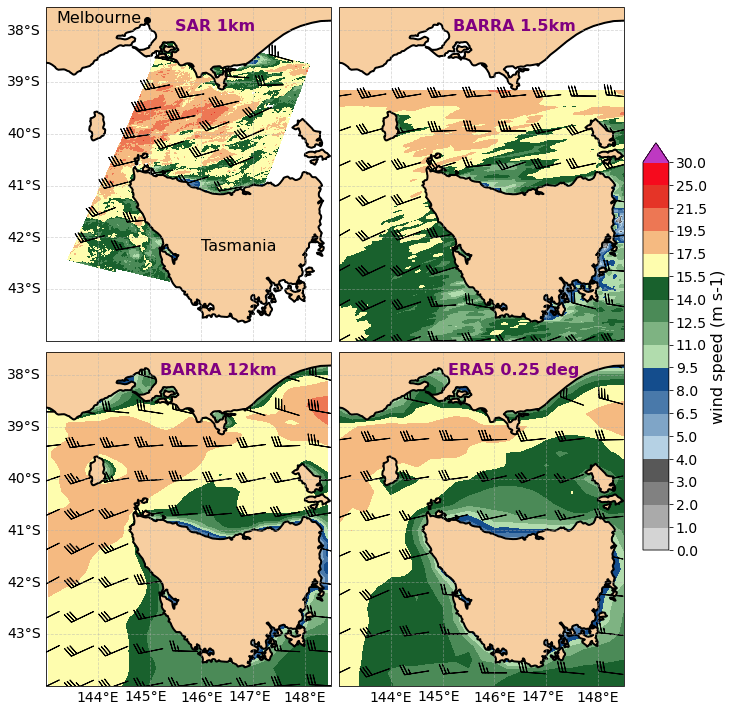

In [56]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (11, 10), 
                         subplot_kw = {'projection': cart.crs.PlateCarree()}, sharey = True)

# SAR wind map
ax = axes[0, 0]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.plot(144.96, -37.81, 'ko')
ax.text(143.2, -37.85, 'Melbourne', fontsize = 16, color = 'black');
ax.text(146, -42.25, 'Tasmania', fontsize = 16, color = 'black');
ax.text(145.5, -38, 'SAR 1km', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
# plot wind speed 
for dset in dset_list:
    cs = ax.contourf(dset['LONGITUDE'], dset['LATITUDE'], dset['WSPD_CAL'], 
                   levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
               colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.right_labels = None
gl.bottom_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# add wind barbs
fact = 60
slc = slice(None, None, fact)
for dset in dset_list:
    uv = to_uv(dset['WSPD_CAL'] * mps2knots, met2math(dset['WDIR']))
    u = uv[0]
    v = uv[1]
    ax.barbs(dset['LONGITUDE'].isel(TIME = slc, RANGE = slc),
              dset['LATITUDE'].isel(TIME = slc, RANGE = slc), 
              u.isel(TIME = slc, RANGE = slc), 
              v.isel(TIME = slc, RANGE = slc),
              pivot = 'middle', transform = cart.crs.PlateCarree(), 
              color = 'k', rounding = True)    

# BARRA-Tas 1.5 km wind map
ax = axes[0, 1]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.text(145.2, -38, 'BARRA 1.5km', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
#plot wind speed
cs = ax.contourf(uwnd_ta['longitude'], uwnd_ta['latitude'], np.sqrt(uwnd_ta**2 + vwnd_ta**2), 
               levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
           colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.right_labels = None
gl.bottom_labels = None
gl.left_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

# add wind barbs
slc = slice(None, None, 50)
ax.barbs(uwnd_ta['longitude'].isel(longitude = slc),
         uwnd_ta['latitude'].isel(latitude = slc), 
         mps2knots*uwnd_ta.isel(longitude = slc, latitude = slc), 
         mps2knots*vwnd_ta.isel(longitude = slc, latitude = slc), 
         pivot = 'middle', transform = cart.crs.PlateCarree(), 
         color = 'k', rounding = True)

# BARRA-R 12 km wind map
ax = axes[1, 0]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.text(145.2, -38, 'BARRA 12km', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
#plot wind speed
cs = ax.contourf(uwnd_r['longitude'], uwnd_r['latitude'], np.sqrt(uwnd_r**2 + vwnd_r**2), 
               levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
           colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.right_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# plot wind barbs
slc = slice(None, None, 6)
ax.barbs(uwnd_r['longitude'].isel(longitude = slc),
         uwnd_r['latitude'].isel(latitude = slc), 
         mps2knots*uwnd_r.isel(longitude = slc, latitude = slc), 
         mps2knots*vwnd_r.isel(longitude = slc, latitude = slc), 
         pivot = 'middle', transform = cart.crs.PlateCarree(), 
         color = 'k', rounding = True)   

# ERA5 0.25 deg wind map
ax = axes[1, 1]
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land_10m, edgecolor='k', facecolor = land_clr, linewidth = 2)
ax.add_feature(cfeature.STATES, linestyle = ':')
ax.text(145.1, -38, 'ERA5 0.25 deg', fontsize = 16, color = 'purple', fontweight = 'semibold');
ax.set_extent(extent)
# plot wind speed
cs = ax.contourf(u10_era5['longitude'], u10_era5['latitude'], np.sqrt(u10_era5**2 + v10_era5**2), 
               levels = levels, transform = cart.crs.PlateCarree(), extend = 'max',
           colors = contour_clrs)    
gl = ax.gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
gl.top_labels = None
gl.left_labels = None
gl.right_labels = None
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# add wind barbs
slc = slice(None, None, 3)
ax.barbs(u10_era5['longitude'].isel(longitude = slc),
         u10_era5['latitude'].isel(latitude = slc), 
         mps2knots*u10_era5.isel(longitude = slc, latitude = slc), 
         mps2knots*v10_era5.isel(longitude = slc, latitude = slc), 
         pivot = 'middle', transform = cart.crs.PlateCarree(), 
         color = 'k', rounding = True)
fig.tight_layout();

# Add colorbar to figure
cbar = fig.colorbar(cs, ax = axes, orientation = 'vertical', 
         label = 'wind speed (m s-1)', aspect = 15,
         shrink = 0.6, pad = 0.025)
cbar.ax.tick_params(labelsize = 14)
cbar.set_label(label = 'wind speed (m s-1)', size = 16)
cbar.set_ticks(levels)
cbar.set_ticklabels(levels)
